In [ ]:
!nvidia-smi

Tue Aug 22 16:06:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

BASE_PATH = r'./gdrive/MyDrive/lfsa/'

Mounted at /content/gdrive


# Preprocessing

In [ ]:
import os
import random
import torch
import numpy as np
import json
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from torchvision.transforms import Compose, Normalize
from sklearn.model_selection import train_test_split
# import tracemalloc

In [ ]:
class SpecDataset(Dataset):
  def __init__(self, data, label2class, maxval, minval, normalize=False, do_label_trans = True):
    self.data = data
    self.labels = self.data.iloc[:, -1].map(label2class).values if do_label_trans else self.data.iloc[:, -1].values
    self.features = self.data.iloc[:, :-1].values
    self.normalize = normalize
    self.maxval, self.minval = maxval, minval

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    feature = torch.unsqueeze(torch.tensor(self.features[idx], dtype=torch.float), 0)
    label = torch.tensor(self.labels[idx], dtype=torch.long)

    # feature = torch.tensor(self.features[idx], dtype=torch.float)
    # label = torch.tensor(self.labels[idx], dtype=torch.long)

    if self.normalize:
        #   feature = self.transform(feature)
        noise = torch.randn_like(feature) * 0.000
        feature = feature + noise
        feature = (feature - self.minval) / self.maxval
        # feature = (feature - self.mean) / self.std


    return feature, label

In [ ]:


# tracemalloc.start()

csv_path = os.path.join(BASE_PATH, 'data_84_85_576_v0_c2000_fil.csv')

train_proportion = 0.9
val_proportion = 1 - train_proportion

data = pd.read_csv(csv_path)
data.iloc[:, -1] = data.iloc[:, -1].apply(lambda s: int(s))
unique_labels = data.iloc[:, -1].unique()

# snapshot = tracemalloc.take_snapshot()
# top_stats = snapshot.statistics('lineno')

# # Print the memory usage for the top 10 lines
# for stat in top_stats[:10]:
#     print(stat)

# get only n labels
print(type(unique_labels))
# np.random.seed(57)
# selected_labels = random.sample(list(unique_labels), 173)
# data = data[data.iloc[:, -1].isin(selected_labels)]
# print(selected_labels)

all_values = data.iloc[:, :-1].values.tolist()
# mean_values = np.mean(all_values)
# std_values = 1
max_value = np.max(all_values)
min_value = np.min(all_values)
# print(f"mean: {mean_values}, std: {std_values}, max: {max_value}, min: {min_value}")
# normalize_transform = Normalize(mean=mean_values, std=std_values)

print(data.iloc[:, -1])
unique_labels = data.iloc[:, -1].unique()
print(unique_labels)
label2class = {int(label): idx for idx, label in enumerate(unique_labels)}
class2label = {idx: int(label) for idx, label in enumerate(unique_labels)}

with open(os.path.join(BASE_PATH, 'label2class_mapping_c2000.json'), 'w') as json_file:
    json.dump(label2class, json_file)
with open(os.path.join(BASE_PATH, 'class2label_mapping_c2000.json'), 'w') as json_file:
    json.dump(class2label, json_file)

# dataset = SpecDataset(csv_path, label2class, mean_values, std_values, transform=normalize_transform)

train_df, rem_df = train_test_split(data, train_size=0.8, random_state=57)
valid_df, test_df = train_test_split(rem_df, test_size=0.5, random_state=57)
train_set = SpecDataset(train_df, label2class, max_value, min_value, normalize=True)
valid_set = SpecDataset(valid_df, label2class, max_value, min_value, normalize=True)
test_set = SpecDataset(test_df, label2class, max_value, min_value, normalize=True)

del all_values

# train_size = int(train_proportion * len(dataset))
# val_size = len(dataset) - train_size

# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True)


# Split the dataset into training and validation sets
# train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(57))

batch_size = 32
num_workers = 2
pin_memory = True

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

<class 'numpy.ndarray'>
0         26502
1         26502
2         26502
3         26502
4         26502
          ...  
138795    94501
138796    94501
138797    94501
138798    94501
138799    94501
Name: 2000, Length: 138800, dtype: int64
[ 26502  39508  34504  39509  13502  39510  32502  32504  40510  30514
  32512  40514  38502  33502  40517  43502  38508  33506  41503  52508
  46502  47508  52513  43510  49510  47511  47512  47515  46512  43517
  47516  47517  46514  47518  45512  45513  46518  45515  45516  46520
  44504  50513  46521  42518  51528  44506  44507  46524  48510  45524
  54514  56509  52507  56510  64516  58505  56511  54518  60505  64519
  58508  65501  54521  61513  62523  53512  65502  60509  62524  53513
  61514  55502  61515  53515  58513  56519  61516  55505  65506  58514
  61517  65507  58515  61518  56522  65508  55507  58516  60517  63506
  57502  58517  55509  65510  60518  55513  58518  60519  54504  55515
  58519  64502  65514  62503  54506  60521  57507

In [ ]:
#@title
"""
resnet for 1-d signal data, pytorch version

Shenda Hong, Oct 2019
"""

import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MyConv1dPadSame(nn.Module):
    """
    extend nn.Conv1d to support SAME padding
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(MyConv1dPadSame, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            groups=self.groups)

    def forward(self, x):

        net = x

        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)

        net = self.conv(net)

        return net

class MyMaxPool1dPadSame(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding
    """
    def __init__(self, kernel_size):
        super(MyMaxPool1dPadSame, self).__init__()
        self.kernel_size = kernel_size
        self.stride = 1
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):

        net = x

        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)

        net = self.max_pool(net)

        return net

class BasicBlock(nn.Module):
    """
    ResNet Basic Block
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups, downsample, use_bn, use_do, is_first_block=False):
        super(BasicBlock, self).__init__()

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.stride = stride
        self.groups = groups
        self.downsample = downsample
        if self.downsample:
            self.stride = stride
        else:
            self.stride = 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.use_do = use_do

        # the first conv
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.5)
        self.conv1 = MyConv1dPadSame(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=self.stride,
            groups=self.groups)

        # the second conv
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.5)
        self.conv2 = MyConv1dPadSame(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            groups=self.groups)

        self.max_pool = MyMaxPool1dPadSame(kernel_size=self.stride)

    def forward(self, x):

        identity = x

        # the first conv
        out = x
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.relu1(out)
            if self.use_do:
                out = self.do1(out)
        out = self.conv1(out)

        # the second conv
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        if self.use_do:
            out = self.do2(out)
        out = self.conv2(out)

        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)

        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1,-2)
            ch1 = (self.out_channels-self.in_channels)//2
            ch2 = self.out_channels-self.in_channels-ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1,-2)

        # shortcut
        out += identity

        return out

class ResNet1D(nn.Module):
    """

    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)

    Output:
        out: (n_samples)

    Pararmetes:
        in_channels: dim of input, the same as n_channel
        base_filters: number of filters in the first several Conv layer, it will double at every 4 layers
        kernel_size: width of kernel
        stride: stride of kernel moving
        groups: set larget to 1 as ResNeXt
        n_block: number of blocks
        n_classes: number of classes

    """

    def __init__(self, in_channels, base_filters, kernel_size, stride, groups, n_block, n_classes, downsample_gap=2, increasefilter_gap=4, use_bn=True, use_do=True, verbose=False):
        super(ResNet1D, self).__init__()

        self.verbose = verbose
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.use_bn = use_bn
        self.use_do = use_do

        self.downsample_gap = downsample_gap # 2 for base model
        self.increasefilter_gap = increasefilter_gap # 4 for base model

        # first block
        self.first_block_conv = MyConv1dPadSame(in_channels=in_channels, out_channels=base_filters, kernel_size=self.kernel_size, stride=1)
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = nn.ReLU()
        out_channels = base_filters

        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(base_filters*2**((i_block-1)//self.increasefilter_gap))
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels

            tmp_block = BasicBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=self.kernel_size,
                stride = self.stride,
                groups = self.groups,
                downsample=downsample,
                use_bn = self.use_bn,
                use_do = self.use_do,
                is_first_block=is_first_block)
            self.basicblock_list.append(tmp_block)

        # final prediction
        self.final_bn = nn.BatchNorm1d(out_channels)
        self.final_relu = nn.ReLU(inplace=True)
        # self.do = nn.Dropout(p=0.5)
        self.dense = nn.Linear(out_channels, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        out = x

        # first conv
        if self.verbose:
            print('input shape', out.shape)
        out = self.first_block_conv(out)
        if self.verbose:
            print('after first conv', out.shape)
        if self.use_bn:
            out = self.first_block_bn(out)
        out = self.first_block_relu(out)

        # residual blocks, every block has two conv
        for i_block in range(self.n_block):
            net = self.basicblock_list[i_block]
            if self.verbose:
                print('i_block: {0}, in_channels: {1}, out_channels: {2}, downsample: {3}'.format(i_block, net.in_channels, net.out_channels, net.downsample))
            out = net(out)
            if self.verbose:
                print(out.shape)


        # final prediction
        if self.use_bn:
            out = self.final_bn(out)
        out = self.final_relu(out)
        out = out.mean(-1)
        if self.verbose:
            print('final pooling', out.shape)
        # out = self.do(out)
        out = self.dense(out)
        if self.verbose:
            print('dense', out.shape)
        # out = self.softmax(out)
        if self.verbose:
            print('softmax', out.shape)

        return out

In [ ]:
import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import copy

# Build model

In [ ]:
# @title
class Conv1dNet3(nn.Module):
  def __init__(self, base_filters, kernel_size, stride, n_classes):
    super(Conv1dNet3, self).__init__()

    self.base_filters = base_filters
    self.kernel_size = kernel_size
    self.stride = stride


    self.conv1 = torch.nn.Conv1d(
            in_channels=1,
            out_channels=16,
            kernel_size=self.kernel_size,
            stride=self.stride)
    self.relu1 = nn.ReLU()
    self.maxpool1 = torch.nn.MaxPool1d(kernel_size=self.kernel_size, stride=2)
    self.conv2 = torch.nn.Conv1d(
            in_channels=16,
            out_channels=32,
            kernel_size=self.kernel_size,
            stride=self.stride)
    self.relu2 = nn.ReLU()
    self.maxpool2 = torch.nn.MaxPool1d(kernel_size=self.kernel_size, stride=2)
    self.conv3 = torch.nn.Conv1d(
            in_channels=32,
            out_channels=64,
            kernel_size=self.kernel_size,
            stride=self.stride)
    self.relu3 = nn.ReLU()
    self.maxpool3 = torch.nn.MaxPool1d(kernel_size=self.kernel_size, stride=2)

    self.final_relu = nn.ReLU(inplace=True)
    self.dense = nn.Linear(15552, n_classes)
    self.final_sm = nn.Softmax(dim=1)

  def forward(self, x):
    out = x
    out = self.maxpool1(self.relu1(self.conv1(out)))
    out = self.maxpool2(self.relu2(self.conv2(out)))
    out = self.maxpool3(self.relu3(self.conv3(out)))
    # out = self.final_relu(out)
    out = out.view(out.size(0), -1)
    out = self.dense(out)
    # out = self.final_sm(out)

    return out

In [ ]:
# make model
device_str = "cuda"
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
kernel_size = 5
stride = 2
n_block = 3
downsample_gap = 1
increasefilter_gap = 1

model = Conv1dNet3(
    base_filters = 16,
    kernel_size = 5,
    stride = 1,
    n_classes = 241
)
model.to(device)

summary(model, (1, 2000), device=device_str)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 1996]              96
              ReLU-2             [-1, 16, 1996]               0
         MaxPool1d-3              [-1, 16, 996]               0
            Conv1d-4              [-1, 32, 992]           2,592
              ReLU-5              [-1, 32, 992]               0
         MaxPool1d-6              [-1, 32, 494]               0
            Conv1d-7              [-1, 64, 490]          10,304
              ReLU-8              [-1, 64, 490]               0
         MaxPool1d-9              [-1, 64, 243]               0
           Linear-10                  [-1, 241]       3,748,273
Total params: 3,761,265
Trainable params: 3,761,265
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.81
Params size (MB): 14.35
Estima

# Training

In [ ]:
# train and test
model.verbose = False
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3)
loss_func = torch.nn.CrossEntropyLoss()

n_epoch = 45
step = 0

# Set early stopping parameters
patience = 6
min_delta = 0.001
best_val_loss = float('inf')
epochs_without_improvement = 0

best_model_state = None

for epoch in tqdm(range(n_epoch), desc="epoch", position=0, leave=True):

    # train
    model.train()
    prog_iter = tqdm(train_loader, desc="Training", position=0, leave=True)
    train_loss = []
    train_accs = []

    for batch_idx, batch in enumerate(prog_iter):

        input_x, labels = tuple(t.to(device) for t in batch)
        # print(input_x.size())
        logits = model(input_x)
        loss = loss_func(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        # print(f"logits: {logits.argmax(dim=-1)}, labels: {labels.to(device)}")

        train_loss.append(loss.item())
        train_accs.append(acc)

        step += 1
        # if step > 10:
        #   break



    scheduler.step(epoch)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epoch:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")


    # test
    model.eval()
    prog_iter_test = tqdm(val_loader, desc="Validating", position=0, leave=True)
    all_pred_prob = []

    valid_loss = []
    valid_accs = []
    valid_ys = []



    with torch.no_grad():
        for batch_idx, batch in enumerate(prog_iter_test):
            input_x, labels = tuple(t.to(device) for t in batch)
            logits = model(input_x)

            # We can still compute the loss (but not the gradient).
            loss = loss_func(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            # print(f"logits: {logits.argmax(dim=-1)}, labels: {labels.to(device)}")
            if epoch == n_epoch-1:
                valid_ys.extend(logits.argmax(dim=-1))

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"\n[ Valid | {epoch + 1:03d}/{n_epoch:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        # Check for early stopping
        if valid_loss + min_delta < best_val_loss:
            best_val_loss = valid_loss
            epochs_without_improvement = 0
            best_model_state = copy.deepcopy(model.state_dict())
            # torch.save(model.state_dict(), SAVE_PATH)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Early stopping: Validation loss did not improve for {} consecutive epochs.".format(patience))
            break



Training: 100%|██████████| 3470/3470 [00:16<00:00, 215.30it/s]


[ Train | 001/045 ] loss = 2.71981, acc = 0.54967


epoch:   2%|▏         | 1/45 [00:17<12:33, 17.12s/it]


[ Valid | 001/045 ] loss = 2.41874, acc = 0.60733


Training: 100%|██████████| 3470/3470 [00:15<00:00, 230.42it/s]


[ Train | 002/045 ] loss = 1.84427, acc = 0.70032


epoch:   4%|▍         | 2/45 [00:33<11:49, 16.51s/it]


[ Valid | 002/045 ] loss = 1.44764, acc = 0.79186


Training: 100%|██████████| 3470/3470 [00:15<00:00, 229.97it/s]


[ Train | 003/045 ] loss = 1.53767, acc = 0.74365


epoch:   7%|▋         | 3/45 [00:49<11:27, 16.38s/it]


[ Valid | 003/045 ] loss = 1.27531, acc = 0.76521


Training: 100%|██████████| 3470/3470 [00:15<00:00, 229.37it/s]


[ Train | 004/045 ] loss = 1.29323, acc = 0.78130


epoch:   9%|▉         | 4/45 [01:05<11:07, 16.28s/it]


[ Valid | 004/045 ] loss = 1.24836, acc = 0.79619


Training: 100%|██████████| 3470/3470 [00:15<00:00, 230.36it/s]


[ Train | 005/045 ] loss = 1.13296, acc = 0.81257


epoch:  11%|█         | 5/45 [01:21<10:47, 16.20s/it]


[ Valid | 005/045 ] loss = 1.15013, acc = 0.84352


Training: 100%|██████████| 3470/3470 [00:14<00:00, 232.69it/s]


[ Train | 006/045 ] loss = 0.96201, acc = 0.84397


epoch:  13%|█▎        | 6/45 [01:37<10:28, 16.12s/it]


[ Valid | 006/045 ] loss = 1.12344, acc = 0.84929


Training: 100%|██████████| 3470/3470 [00:15<00:00, 225.13it/s]


[ Train | 007/045 ] loss = 0.86984, acc = 0.86146


epoch:  16%|█▌        | 7/45 [01:54<10:16, 16.22s/it]


[ Valid | 007/045 ] loss = 0.76825, acc = 0.86887


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.79it/s]


[ Train | 008/045 ] loss = 0.80601, acc = 0.86999


epoch:  18%|█▊        | 8/45 [02:10<10:00, 16.24s/it]


[ Valid | 008/045 ] loss = 0.65834, acc = 0.89751


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.02it/s]


[ Train | 009/045 ] loss = 0.74053, acc = 0.87957


epoch:  20%|██        | 9/45 [02:26<09:45, 16.26s/it]


[ Valid | 009/045 ] loss = 0.76413, acc = 0.85895


Training: 100%|██████████| 3470/3470 [00:15<00:00, 229.51it/s]


[ Train | 010/045 ] loss = 0.65968, acc = 0.89356


epoch:  22%|██▏       | 10/45 [02:42<09:29, 16.26s/it]


[ Valid | 010/045 ] loss = 0.96004, acc = 0.86672


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.64it/s]


[ Train | 011/045 ] loss = 0.63229, acc = 0.89806


epoch:  24%|██▍       | 11/45 [02:59<09:13, 16.28s/it]


[ Valid | 011/045 ] loss = 0.52391, acc = 0.92810


Training: 100%|██████████| 3470/3470 [00:15<00:00, 229.10it/s]


[ Train | 012/045 ] loss = 0.58791, acc = 0.90291


epoch:  27%|██▋       | 12/45 [03:15<08:56, 16.25s/it]


[ Valid | 012/045 ] loss = 0.60618, acc = 0.87013


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.24it/s]


[ Train | 013/045 ] loss = 0.55109, acc = 0.90969


epoch:  29%|██▉       | 13/45 [03:31<08:41, 16.30s/it]


[ Valid | 013/045 ] loss = 0.51571, acc = 0.90231


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.40it/s]


[ Train | 014/045 ] loss = 0.50590, acc = 0.91515


epoch:  31%|███       | 14/45 [03:48<08:25, 16.31s/it]


[ Valid | 014/045 ] loss = 0.56795, acc = 0.90859


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.91it/s]


[ Train | 015/045 ] loss = 0.48762, acc = 0.91806


epoch:  33%|███▎      | 15/45 [04:04<08:08, 16.29s/it]


[ Valid | 015/045 ] loss = 0.56284, acc = 0.88971


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.99it/s]


[ Train | 016/045 ] loss = 0.45920, acc = 0.92104


epoch:  36%|███▌      | 16/45 [04:20<07:52, 16.28s/it]


[ Valid | 016/045 ] loss = 0.61202, acc = 0.87905


Training: 100%|██████████| 3470/3470 [00:15<00:00, 228.87it/s]


[ Train | 017/045 ] loss = 0.45552, acc = 0.92445


epoch:  38%|███▊      | 17/45 [04:36<07:35, 16.27s/it]


[ Valid | 017/045 ] loss = 0.38720, acc = 0.93400


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.16it/s]


[ Train | 018/045 ] loss = 0.41714, acc = 0.93102


epoch:  40%|████      | 18/45 [04:53<07:20, 16.30s/it]


[ Valid | 018/045 ] loss = 0.51220, acc = 0.89598


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.43it/s]


[ Train | 019/045 ] loss = 0.40658, acc = 0.93288


epoch:  42%|████▏     | 19/45 [05:09<07:03, 16.30s/it]


[ Valid | 019/045 ] loss = 0.47003, acc = 0.92933


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.26it/s]


[ Train | 020/045 ] loss = 0.38968, acc = 0.93578


epoch:  44%|████▍     | 20/45 [05:25<06:48, 16.32s/it]


[ Valid | 020/045 ] loss = 0.40985, acc = 0.91875


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.14it/s]


[ Train | 021/045 ] loss = 0.39222, acc = 0.93613


epoch:  47%|████▋     | 21/45 [05:42<06:32, 16.37s/it]


[ Valid | 021/045 ] loss = 0.35327, acc = 0.93236


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.56it/s]


[ Train | 022/045 ] loss = 0.35169, acc = 0.94099


epoch:  49%|████▉     | 22/45 [05:58<06:16, 16.35s/it]


[ Valid | 022/045 ] loss = 0.46818, acc = 0.92471


Training: 100%|██████████| 3470/3470 [00:15<00:00, 225.67it/s]


[ Train | 023/045 ] loss = 0.34647, acc = 0.94291


epoch:  51%|█████     | 23/45 [06:15<05:59, 16.36s/it]


[ Valid | 023/045 ] loss = 0.36219, acc = 0.94734


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.68it/s]


[ Train | 024/045 ] loss = 0.33719, acc = 0.94582


epoch:  53%|█████▎    | 24/45 [06:31<05:44, 16.40s/it]


[ Valid | 024/045 ] loss = 0.29776, acc = 0.95555


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.55it/s]


[ Train | 025/045 ] loss = 0.33331, acc = 0.94407


epoch:  56%|█████▌    | 25/45 [06:47<05:27, 16.39s/it]


[ Valid | 025/045 ] loss = 0.29571, acc = 0.95937


Training: 100%|██████████| 3470/3470 [00:15<00:00, 229.15it/s]


[ Train | 026/045 ] loss = 0.31126, acc = 0.95053


epoch:  58%|█████▊    | 26/45 [07:04<05:10, 16.34s/it]


[ Valid | 026/045 ] loss = 0.32233, acc = 0.96009


Training: 100%|██████████| 3470/3470 [00:15<00:00, 228.21it/s]


[ Train | 027/045 ] loss = 0.31419, acc = 0.95008


epoch:  60%|██████    | 27/45 [07:20<04:54, 16.34s/it]


[ Valid | 027/045 ] loss = 0.28464, acc = 0.96124


Training: 100%|██████████| 3470/3470 [00:15<00:00, 227.03it/s]


[ Train | 028/045 ] loss = 0.30985, acc = 0.94974


epoch:  62%|██████▏   | 28/45 [07:36<04:38, 16.36s/it]


[ Valid | 028/045 ] loss = 0.28078, acc = 0.96246


Training: 100%|██████████| 3470/3470 [00:15<00:00, 228.53it/s]


[ Train | 029/045 ] loss = 0.29696, acc = 0.95093


epoch:  64%|██████▍   | 29/45 [07:53<04:21, 16.32s/it]


[ Valid | 029/045 ] loss = 0.28289, acc = 0.95217


Training: 100%|██████████| 3470/3470 [00:15<00:00, 224.23it/s]


[ Train | 030/045 ] loss = 0.28896, acc = 0.95303


epoch:  67%|██████▋   | 30/45 [08:09<04:05, 16.37s/it]


[ Valid | 030/045 ] loss = 0.30082, acc = 0.96002


Training: 100%|██████████| 3470/3470 [00:15<00:00, 225.90it/s]


[ Train | 031/045 ] loss = 0.28210, acc = 0.95603


epoch:  69%|██████▉   | 31/45 [08:26<03:49, 16.40s/it]


[ Valid | 031/045 ] loss = 0.25886, acc = 0.96355


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.04it/s]


[ Train | 032/045 ] loss = 0.27900, acc = 0.95548


epoch:  71%|███████   | 32/45 [08:42<03:33, 16.41s/it]


[ Valid | 032/045 ] loss = 0.27966, acc = 0.96045


Training: 100%|██████████| 3470/3470 [00:15<00:00, 223.29it/s]


[ Train | 033/045 ] loss = 0.27610, acc = 0.95509


epoch:  73%|███████▎  | 33/45 [08:59<03:17, 16.47s/it]


[ Valid | 033/045 ] loss = 0.26844, acc = 0.96448


Training: 100%|██████████| 3470/3470 [00:15<00:00, 225.95it/s]


[ Train | 034/045 ] loss = 0.26866, acc = 0.95874


epoch:  76%|███████▌  | 34/45 [09:15<03:01, 16.48s/it]


[ Valid | 034/045 ] loss = 0.26011, acc = 0.96470


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.83it/s]


[ Train | 035/045 ] loss = 0.26236, acc = 0.95801


epoch:  78%|███████▊  | 35/45 [09:31<02:44, 16.42s/it]


[ Valid | 035/045 ] loss = 0.27745, acc = 0.96319


Training: 100%|██████████| 3470/3470 [00:15<00:00, 228.21it/s]


[ Train | 036/045 ] loss = 0.26085, acc = 0.95778


epoch:  80%|████████  | 36/45 [09:48<02:27, 16.38s/it]


[ Valid | 036/045 ] loss = 0.27439, acc = 0.96327


Training: 100%|██████████| 3470/3470 [00:15<00:00, 228.83it/s]


[ Train | 037/045 ] loss = 0.25944, acc = 0.95923


epoch:  82%|████████▏ | 37/45 [10:04<02:10, 16.32s/it]


[ Valid | 037/045 ] loss = 0.23931, acc = 0.96412


Training: 100%|██████████| 3470/3470 [00:15<00:00, 224.81it/s]


[ Train | 038/045 ] loss = 0.25118, acc = 0.96071


epoch:  84%|████████▍ | 38/45 [10:20<01:54, 16.35s/it]


[ Valid | 038/045 ] loss = 0.23578, acc = 0.96628


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.78it/s]


[ Train | 039/045 ] loss = 0.24905, acc = 0.96079


epoch:  87%|████████▋ | 39/45 [10:37<01:38, 16.35s/it]


[ Valid | 039/045 ] loss = 0.25234, acc = 0.96809


Training: 100%|██████████| 3470/3470 [00:15<00:00, 228.39it/s]


[ Train | 040/045 ] loss = 0.24452, acc = 0.96185


epoch:  89%|████████▉ | 40/45 [10:53<01:21, 16.32s/it]


[ Valid | 040/045 ] loss = 0.25510, acc = 0.96448


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.77it/s]


[ Train | 041/045 ] loss = 0.24560, acc = 0.96182


epoch:  91%|█████████ | 41/45 [11:09<01:05, 16.34s/it]


[ Valid | 041/045 ] loss = 0.24040, acc = 0.96693


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.72it/s]


[ Train | 042/045 ] loss = 0.24234, acc = 0.96219


epoch:  93%|█████████▎| 42/45 [11:26<00:49, 16.34s/it]


[ Valid | 042/045 ] loss = 0.23303, acc = 0.96499


Training: 100%|██████████| 3470/3470 [00:15<00:00, 224.89it/s]


[ Train | 043/045 ] loss = 0.23806, acc = 0.96237


epoch:  96%|█████████▌| 43/45 [11:42<00:32, 16.37s/it]


[ Valid | 043/045 ] loss = 0.23280, acc = 0.96585


Training: 100%|██████████| 3470/3470 [00:15<00:00, 223.80it/s]


[ Train | 044/045 ] loss = 0.23671, acc = 0.96278


epoch:  98%|█████████▊| 44/45 [11:59<00:16, 16.44s/it]


[ Valid | 044/045 ] loss = 0.23667, acc = 0.96765


Training: 100%|██████████| 3470/3470 [00:15<00:00, 226.86it/s]


[ Train | 045/045 ] loss = 0.23454, acc = 0.96349


epoch: 100%|██████████| 45/45 [12:15<00:00, 16.35s/it]


[ Valid | 045/045 ] loss = 0.24748, acc = 0.96830


# Save model

In [ ]:
SAVE_PATH = os.path.join(BASE_PATH, 'lfsa_model/best-model-parameters-v0-576-c2000.pt')

In [ ]:
torch.save(best_model_state, SAVE_PATH)

# Test on test set

In [ ]:
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()

loss_func = torch.nn.CrossEntropyLoss()

prog_iter_test = tqdm(test_loader, desc="Testing", position=0, leave=True)
all_pred_prob = []

test_loss = []
test_accs = []
test_ys = []

with torch.no_grad():
    for batch_idx, batch in enumerate(prog_iter_test):
        input_x, labels = tuple(t.to(device) for t in batch)
        logits = model(input_x)

        # We can still compute the loss (but not the gradient).
        loss = loss_func(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        # print(f"logits: {logits.argmax(dim=-1)}, labels: {labels.to(device)}")

        # Record the loss and accuracy.
        test_loss.append(loss.item())
        test_accs.append(acc)

    # The average loss and accuracy for entire testing set is the average of the recorded values.
    test_loss = sum(test_loss) / len(test_loss)
    test_acc = sum(test_accs) / len(test_accs)

    # Print the information.
    print(f"\n[ Testing: loss = {test_loss:.5f}, acc = {test_acc:.5f} ]")


Testing: 100%|██████████| 217/217 [00:01<00:00, 155.87it/s]


[ Testing: loss = 0.24880, acc = 0.96003 ]


# Inference

In [ ]:
data_path = "mock_spec_in.csv"
obs_data_path = os.path.join(BASE_PATH, data_path)
obs_data = pd.read_csv(obs_data_path)

with open(os.path.join(BASE_PATH, 'label2class_mapping_c2000.json'), 'r') as json_file:
    label2class = json.load(json_file)

with open(os.path.join(BASE_PATH, 'class2label_mapping_c2000.json'), 'r') as json_file:
    class2label = json.load(json_file)



obs_data.iloc[:, -1] = obs_data.iloc[:, -1].apply(lambda s: str(int(s)))
last_key = str(len(obs_data.columns)-1)
print(len(obs_data))
obs_data = obs_data[obs_data[last_key].map(label2class).notna()]
print(len(obs_data))
# data[data.iloc[:, -1].map(label2class).notna()]

# print(obs_data.iloc[:, -1].map(label2class).values)

all_obs_values = obs_data.iloc[:, :-1].values.tolist()
print(len(all_obs_values))
max_value = np.max(all_obs_values)
min_value = np.min(all_obs_values)
obs_set = SpecDataset(obs_data, label2class, max_value, min_value, normalize=True, do_label_trans=True)
obs_loader = DataLoader(obs_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

model.load_state_dict(torch.load(SAVE_PATH))

prog_iter_obs = tqdm(obs_loader, desc=f"Testing data {data_path}", position=0, leave=True)
all_pred_prob = []

obs_loss = []
obs_accs = []
obs_ys = []
correct = []
incorrect = []

# print("26502" in label2class)

na_count = 0
with torch.no_grad():
    for batch_idx, batch in enumerate(prog_iter_obs):
        input_x, labels = tuple(t.to(device) for t in batch)
        logits = model(input_x)
        # for idx, l in enumerate(labels):
            # if l == label2class["32504"]:
            #     fig = plt.figure(figsize=(12, 8))
            #     plt.plot(np.arange(1918), input_x[idx][0].cpu())

        # We can still compute the loss (but not the gradient).
        # loss = loss_func(logits, labels.to(device))

        # Compute the accuracy for current batch.
        for logit, lab in zip(logits, labels.to(device)):
            top_probs, top_indices = torch.topk(logit, k=2)
            # print(logit)
            confidence_scores = torch.sigmoid(logit)
            # print(f"molecule: {class2label[int(lab)]}, pred: {class2label[int(pred)]}, logit: {torch.max(confidence_scores, dim=0).values}")
            if not str(int(lab)) in label2class:
                # print(label2class)
                # print(f"mole_id: {lab}, pred: {int(pred)}, logit: {torch.max(confidence_scores, dim=0).values}")
                print(f"mole_id: {class2label[str(int(lab))]}, 1-pred: {class2label[str(int(top_indices[0]))]}, 2-pred: {class2label[str(int(top_indices[1]))]}, 1-prob: {top_probs[0]}, 2-prob: {top_probs[1]}")
                na_count += 1
            # if int(lab) == int(pred):
            if int(lab) == int(top_indices[0]):
                correct.append(class2label[str(int(lab))])
            else:
                incorrect.append(class2label[str(int(lab))])

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        # print(f"logits: {logits.argmax(dim=-1)}, labels: {labels.to(device)}")

        # Record the loss and accuracy.
        # obs_loss.append(loss.item())
        obs_accs.append(acc)

    # The average loss and accuracy for entire testing set is the average of the recorded values.
    # obs_loss = sum(obs_loss) / len(obs_loss)
    obs_acc = sum(obs_accs) / len(obs_accs)

    # Print the information.
    print(f"\n[ Testing: acc = {obs_acc:.5f} ]")
    print(f"{len(correct)} in total")
    print(f"correct: {correct}")
    print(f"incorrect: {incorrect}")
    print(f"na_count: {na_count}")


109
109
109


Testing data mock_spec_in.csv:   0%|          | 0/2 [00:00<?, ?it/s]

mole_id: 61505, 1-pred: 61505, 2-pred: 34504, 1-prob: 681661.75, 2-prob: 550646.3125
mole_id: 94501, 1-pred: 61505, 2-pred: 34504, 1-prob: 607879.25, 2-prob: 470394.34375
mole_id: 34504, 1-pred: 61505, 2-pred: 34504, 1-prob: 681661.75, 2-prob: 550646.3125
mole_id: 83502, 1-pred: 61505, 2-pred: 34504, 1-prob: 424224.40625, 2-prob: 351349.0625
mole_id: 80503, 1-pred: 61505, 2-pred: 34504, 1-prob: 665552.5, 2-prob: 535226.125
mole_id: 43517, 1-pred: 61505, 2-pred: 34504, 1-prob: 435935.78125, 2-prob: 362420.1875
mole_id: 56510, 1-pred: 61505, 2-pred: 34504, 1-prob: 434350.1875, 2-prob: 361272.125
mole_id: 55502, 1-pred: 61505, 2-pred: 55515, 1-prob: 436736.375, 2-prob: 374617.75
mole_id: 60505, 1-pred: 61505, 2-pred: 55515, 1-prob: 436736.375, 2-prob: 374617.75
mole_id: 26502, 1-pred: 83506, 2-pred: 60519, 1-prob: 57611.859375, 2-prob: 53906.28125
mole_id: 94503, 1-pred: 94503, 2-pred: 26502, 1-prob: 26628.08203125, 2-prob: 16336.5478515625
mole_id: 83506, 1-pred: 83506, 2-pred: 26502, 1-

Testing data mock_spec_in.csv: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

mole_id: 55515, 1-pred: 62503, 2-pred: 83506, 1-prob: 8968.8330078125, 2-prob: 4571.0322265625
mole_id: 33502, 1-pred: 45512, 2-pred: 74517, 1-prob: 37009.8828125, 2-prob: 32498.765625
mole_id: 60517, 1-pred: 85501, 2-pred: 74517, 1-prob: 197108.03125, 2-prob: 183301.296875
mole_id: 106501, 1-pred: 85501, 2-pred: 74517, 1-prob: 187302.15625, 2-prob: 174678.3125
mole_id: 45516, 1-pred: 85501, 2-pred: 56504, 1-prob: 180637.359375, 2-prob: 131326.203125
mole_id: 67503, 1-pred: 45516, 2-pred: 67503, 1-prob: 14664.2470703125, 2-prob: 12176.6806640625
mole_id: 80505, 1-pred: 45516, 2-pred: 80505, 1-prob: 11464.130859375, 2-prob: 9393.134765625
mole_id: 74503, 1-pred: 76501, 2-pred: 99501, 1-prob: 91423.953125, 2-prob: 83802.984375
mole_id: 49510, 1-pred: 32504, 2-pred: 49510, 1-prob: 36070.80859375, 2-prob: 35087.9453125
mole_id: 32504, 1-pred: 32504, 2-pred: 49510, 1-prob: 36070.80859375, 2-prob: 35087.9453125
mole_id: 57508, 1-pred: 73503, 2-pred: 45512, 1-prob: 32086.478515625, 2-prob: 31

In [ ]:
correct= [61505, 94503, 83506, 83503, 46524, 60519, 47511, 39510, 64516, 61516, 74514, 70505, 46518, 44504, 62503, 60517, 49510, 45512, 93503, 76501, 99502, 41503, 85501, 61502, 54504]
incorrect= [76513, 94501, 34504, 55502, 83502, 80503, 43517, 56510, 26502, 103501, 108501, 58518, 69509, 69510, 69511, 62504, 76521, 76522, 61518, 62524, 83505, 83507, 74519, 80506, 76514, 76518, 76515, 57507, 68506, 76516, 53515, 84503, 56511, 79501, 72505, 75511, 45513, 78505, 67502, 74515, 76519, 104501, 73503, 60999, 61517, 69513, 58515, 58517, 69506, 38502, 59509, 76520, 45515, 83501, 75512, 55515, 76523, 33502, 106501, 70504, 45516, 67503, 80505, 92502, 74503, 32504, 57508, 57512, 58505, 69516, 13502, 72501, 66506, 54508, 73501, 60524, 69518, 72504, 96501, 99501, 58519, 89503, 65514, 61515, 47518, 57509, 38508, 55507, 67504, 44506, 55505, 76503, 56504, 99503, 54507, 65502, 89502, 60523, 58508, 74516, 55513, 66502]
correct.sort()
incorrect.sort()
print(f"correct: {correct}")
print(f"incorrect: {incorrect}")

correct: [39510, 41503, 44504, 45512, 46518, 46524, 47511, 49510, 54504, 60517, 60519, 61502, 61505, 61516, 62503, 64516, 70505, 74514, 76501, 83503, 83506, 85501, 93503, 94503, 99502]
incorrect: [13502, 26502, 32504, 33502, 34504, 38502, 38508, 43517, 44506, 45513, 45515, 45516, 47518, 53515, 54507, 54508, 55502, 55505, 55507, 55513, 55515, 56504, 56510, 56511, 57507, 57508, 57509, 57512, 58505, 58508, 58515, 58517, 58518, 58519, 59509, 60523, 60524, 60999, 61515, 61517, 61518, 62504, 62524, 65502, 65514, 66502, 66506, 67502, 67503, 67504, 68506, 69506, 69509, 69510, 69511, 69513, 69516, 69518, 70504, 72501, 72504, 72505, 73501, 73503, 74503, 74515, 74516, 74519, 75511, 75512, 76503, 76513, 76514, 76515, 76516, 76518, 76519, 76520, 76521, 76522, 76523, 78505, 79501, 80503, 80505, 80506, 83501, 83502, 83505, 83507, 84503, 89502, 89503, 92502, 94501, 96501, 99501, 99503, 103501, 104501, 106501, 108501]


In [ ]:
db_path = os.path.join(BASE_PATH, "database_csv_patched.csv")
db_data = pd.read_csv(db_path)


<ipython-input-16-58dfaca24246>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  db_data = pd.read_csv(db_path)


In [ ]:
import pickle
from tabulate import tabulate

with open(os.path.join(BASE_PATH, "mock_mole_hit_trans_i6.pkl"), 'rb') as f:
    mole_hit_trans_dict = pickle.load(f)
# print(mole_hit_trans_dict)

result_dict = {"id": [], "mole_name": [], "matched_trans_count": []}
correct.sort()
incorrect.sort()
for id in correct:
    result_dict["id"].append(id)
    result_dict["mole_name"].append(db_data[db_data["id"] == id].head(1)["name"].values[0])
    result_dict["matched_trans_count"].append(len(mole_hit_trans_dict[id]))


print(tabulate(result_dict, headers='keys', tablefmt='psql'))

result_dict = {"id": [], "mole_name": [], "matched_trans_count": []}
for id in incorrect:
    result_dict["id"].append(id)
    result_dict["mole_name"].append(db_data[db_data["id"] == id].head(1)["name"].values[0])
    result_dict["matched_trans_count"].append(len(mole_hit_trans_dict[id]))

print(tabulate(result_dict, headers='keys', tablefmt='psql'))

+-------+----------------------+-----------------------+
|    id | mole_name            |   matched_trans_count |
|-------+----------------------+-----------------------|
| 39510 | c-CCC-13-H2          |                     2 |
| 41503 | H2CCNH               |                     1 |
| 44504 | Ethylene oxide       |                     5 |
| 45512 | HC(O)NH2, v=0        |                     4 |
| 46518 | c-C2H4O-18           |                     1 |
| 46524 | C2H5OH,v=0           |                     3 |
| 47511 | a-CH3C-13-H2OH       |                     2 |
| 49510 | NaCN                 |                     1 |
| 54504 | Cyclopropenone       |                     1 |
| 60517 | H2NC(O)NH2           |                     3 |
| 60519 | a-i-C3H7OH           |                     1 |
| 61502 | OC-13-S              |                     1 |
| 61505 | C5H                  |                     4 |
| 61516 | CH2(OD)CHO           |                     2 |
| 62503 | aGg' glycol          


# Training data v.s. valid accuracy
1. temp: 100-300 / 20, ntot: 13-16 / 15 = 300: 0.881
2. temp: 100-300 / 40, ntot: 13-16 / 20 = 800: 0.925
3. temp: 100-300 / 25, ntot: 13-16 / 36 = 900: 0.930
    1.   no noise: 0.98
    2.   0-1normalize: 0.97
4. temp: 100-300 / 32, ntot: 13-16 / 25 = 800,
no noise, 0-1 norm: 0.980
5. temp: 50-370 / 32, ntot: 13-18 / 20 = 640: 0.97

6. temp: 50-370 / 20, ntot: 13-18 /20 = 400: 0.958
7. temp: 50-370 / 12, ntot: 13-18 / 12, fwhm: 1-8 / 4 = 576, 40 epoch: 0.96









# Test velocity - train velocity mismatch v.s. valid accuracy
1. 98 - 98: 0.980
2. 96 - 98: 0.637
3. 94 - 98: 0.579
4. 90 - 98: 0.472

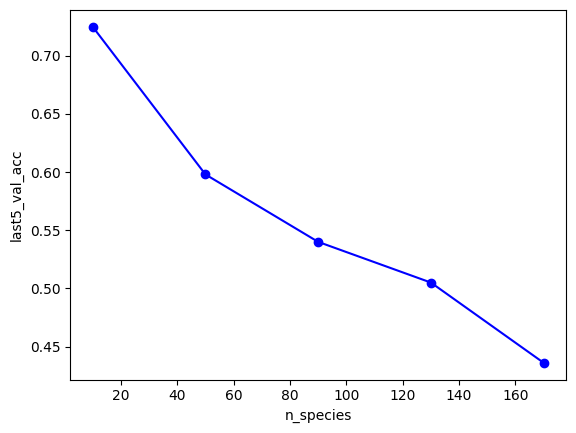

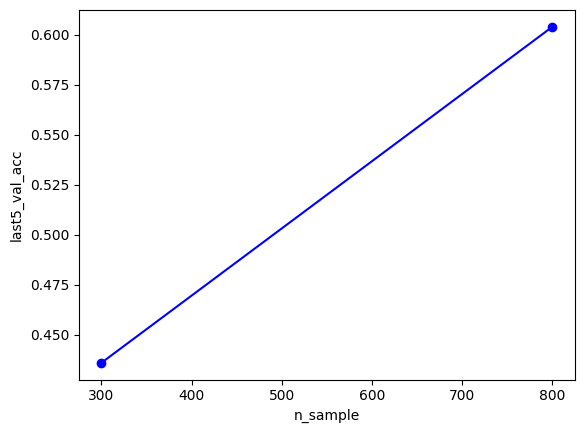

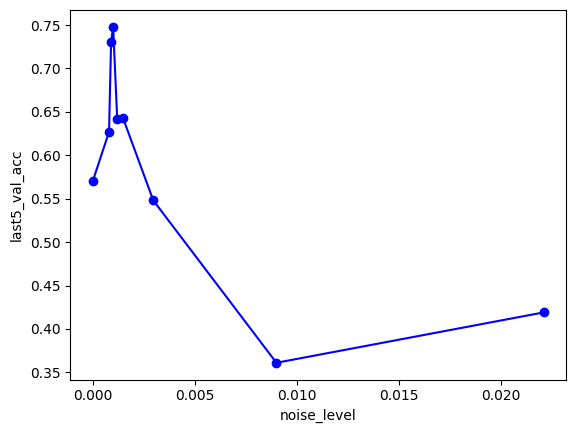

In [ ]:
n_species = [10, 50, 90, 130, 170]
last5_val_acc = [0.725, 0.598, 0.540, 0.505, 0.436]
0.349, 0.436, 0.288
plt.plot(n_species, last5_val_acc, '-bo')
plt.xlabel('n_species')
plt.ylabel('last5_val_acc')
plt.show()

n_sample = [300, 800]
last5_val_acc = [0.436, 0.604]
plt.plot(n_sample, last5_val_acc, '-bo')
plt.xlabel('n_sample')
plt.ylabel('last5_val_acc')
plt.show()

noise_level = [0.     , 0.0008, 0.0009, 0.001, 0.0012    , 0.0014826 , 0.00296752, 0.009, 0.02209074]
last5_val_acc = [0.570, 0.627, 0.730, 0.748, 0.642, 0.643,  0.548, 0.361, 0.419]
plt.plot(noise_level, last5_val_acc, '-bo')
plt.xlabel('noise_level')
plt.ylabel('last5_val_acc')
plt.show()